# Activity Coefficient Models

## Overview

The `polykin.thermo.acm` module provides activity coefficient models to estimate the
thermodynamic properties of nonideal liquid multicomponent solutions.

| Model           | VLE | LLE | Polymer solutions |
|-----------------|:---:|:---:|:-----------------:|
| `NRTL`          |  ✓  |  ✓  |         —         |
| `UNIQUAC`       |  ✓  |  ✓  |         —         |
| `FloryHuggings` |  ✓  |  ✓  |         ✓         |
| `PolyNRTL`      |  ✓  |  ✓  |         ✓         |

For non-polymer solutions, the NRTL and UNIQUAC models stand out as the most popular,
versatile, and overall best-performing alternatives. These models can handle strongly
nonideal mixtures and are applicable to both vapor-liquid (VLE) and liquid-liquid equilibria
(LLE).

In polymer solutions, the Flory-Huggins model remains an indispensable classic, albeit with
somewhat limited performance. For complex solutions, the PolyNRTL model is a far superior
choice, extending the capabilities of the NRTL model to encompass mixtures with polymer
components. 

## Non-polymeric solutions

The `NRTL` and `UNIQUAC` classes are similar in usage and functionality. We provide an example
of VLE calculations with UNIQUAC and an example of LLE calculations with NRTL.

### Binary VLE with UNIQUAC

For this demonstration, let us consider the binary system water / ethylene glycol (EG) with
the UNIQUAC parameters reported by [Lancia et al. (1996)](https://doi.org/10.1252/jcej.29.449).

| Component            | index  |  $r$ | $q$  |
|----------------------|:------:|:----:|------|
| Water                |    1   | 0.92 | 1.4  |
| Ethylene glycol (EG) |    2   | 2.41 | 2.25 |

&nbsp;

| Binary parameter |      1-2        |
|------------------|:---------------:|
| Component $i$    |      Water      |
| Component $j$    | Ethylene glycol |
| $a_{ij}$         |       3.97      |
| $a_{ji}$         |      -10.3      |
| $b_{ij}$ [K]     |      -1194      |
| $b_{ji}$ [K]     |       3359      |

First, we create arrays to store the unary and binary interaction parameters, and then we construct the activity coefficient model object.

In [1]:
# %pip install polykin

In [2]:
from polykin.thermo.acm import UNIQUAC
import numpy as np

# pure-component parameters
r = np.array([0.92, 2.41])
q = np.array([1.4, 2.25])

# binary interaction parameters
N = 2
a = np.zeros((N, N))
b = np.zeros((N, N))
a[0, 1] = 3.974
a[1, 0] = -10.33
b[0, 1] = -1194.
b[1, 0] = 3359.

# model object
acm = UNIQUAC(N, q, r, a=a, b=b) 

We can now evaluate mixing properties, excess properties, activity coefficients, activities, etc. Let us compute and plot the Gibbs energy of mixing, the excess enthalpy, and the activity coefficients as a function of composition at 373 K.

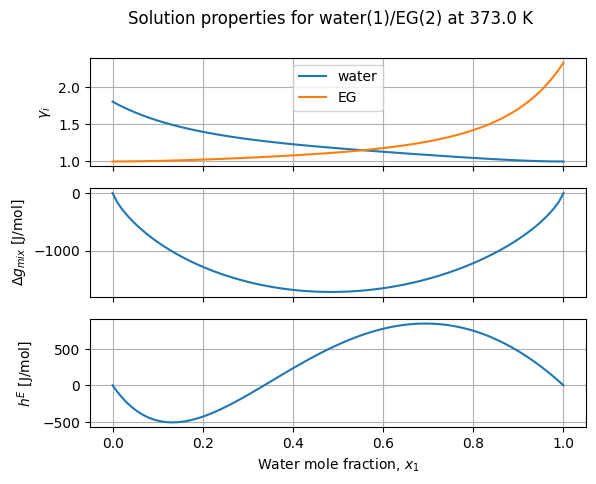

In [3]:
import matplotlib.pyplot as plt

# Evaluate properties on x1 mesh
x1 = np.linspace(0., 1., 100)
T = 373. # K
gamma = []
Dgmix = []
hE = []
for x1val in x1:
    args = (T, np.array([x1val, 1. - x1val]))
    gamma.append(acm.gamma(*args))
    Dgmix.append(acm.Dgmix(*args))
    hE.append(acm.hE(*args))

fig, ax = plt.subplots(3, sharex=True)
fig.suptitle(f"Solution properties for water(1)/EG(2) at {T} K")
ax[-1].set_xlabel(r"Water mole fraction, $x_{1}$")
_ = [axis.grid(True) for axis in ax]

ax[0].set_ylabel(r"$\gamma_{i}$")
gamma = np.asarray(gamma)
ax[0].plot(x1, gamma[:, 0], label="water")
ax[0].plot(x1, gamma[:, 1], label="EG")
ax[0].legend(loc="upper center")

ax[1].set_ylabel(r"$\Delta g_{mix}$ [J/mol]")
ax[1].plot(x1, Dgmix)

ax[2].set_ylabel(r"$h^{E}$ [J/mol]")
ax[2].plot(x1, hE)

The convexity of the $\Delta g_{mix}$ plot indicates that the solution is homogeneous. The activity coefficient plot shows the solution exhibits moderate deviations from Raoult's law, with infinite-dilution activity coefficients of about 2 for both components.

Let us further compute and plot the Pxy diagram for the same conditions. For that, we need the vapor pressures of water and EG, which are also provided in the abovementioned reference.

In [4]:
from polykin.properties.equations import Antoine

In [5]:
# The correlations are in 'mmHg' units, so we conver to 'bar' 
unit_conv = np.log10(1.01325/760)
Psat = [None, None]
Psat[0] = Antoine(A=8.07131 + unit_conv,
                  B=1730.63,
                  C=(233.426 - 273.15),
                  unit="bar",
                  name="water")
Psat[1] = Antoine(A=(8.09083 + unit_conv),
                  B=2088.936,
                  C=(203.454 - 273.15),
                  unit="bar",
                  name="EG")

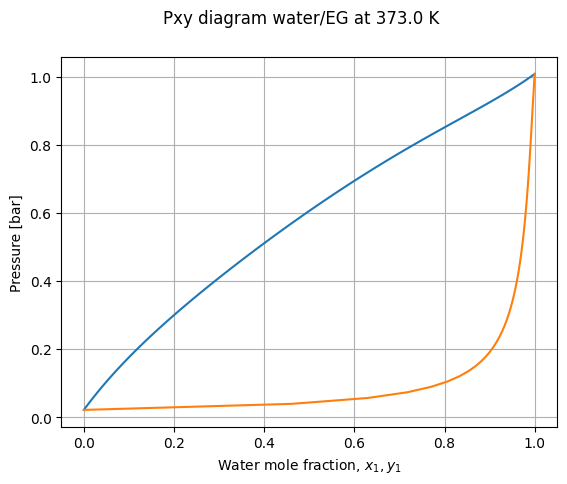

In [6]:
# Bubble pressure, assuming ideal gas phase
Pbubble = x1*gamma[:, 0]*Psat[0](T) + (1. - x1)*gamma[:, 1]*Psat[1](T)

# Vapor composition
y1 = x1*gamma[:, 0]*Psat[0](T)/Pbubble

fig, ax = plt.subplots()
fig.suptitle(f"Pxy diagram water/EG at {T} K")
ax.set_xlabel(r"Water mole fraction, $x_{1}, y_{1}$")
ax.set_ylabel("Pressure [bar]")
ax.grid(True)

ax.plot(x1, Pbubble)
ax.plot(y1, Pbubble)

### Ternary LLE with NRTL

For this demonstration, let us consider the ternary system water(1) / ethanol(2) / ethyl acrylate(3) with the NRTL parameters reported by [Chen et al. (2020)](https://doi.org/10.1016/j.fluid.2020.112555) for the temperature range from 283 to 313 K.

| Binary parameter |   1-2   |       1-3      |       2-3      |
|------------------|:-------:|:--------------:|:--------------:|
| Component $i$    |  water  |      water     |     ethanol    |
| Component $j$    | ethanol | ethyl acrylate | ethyl acrylate |
| $a_{ij}$         |  3.756  |      9.761     |        0       |
| $a_{ji}$         |  -0.985 |     -4.231     |        0       |
| $b_{ij}$ [K]     | -676.03 |    -1451.83    |     -451.54    |
| $b_{ji}$ [K]     |  302.24 |     1577.51    |     1135.61    |
| $\alpha_{ij}$    |   0.3   |       0.2      |       0.2      |

First, we create arrays to store the binary interaction parameters, and then we construct the activity coefficient model object.

In [7]:
from polykin.thermo.acm import NRTL

# binary interaction parameters
N = 3
a = np.zeros((N, N))
b = np.zeros((N, N))
c = np.zeros((N, N))

# water-ethanol
a[0, 1] = 3.756
a[1, 0] = -0.985
b[0, 1] = -676.03
b[1, 0] = 302.24
c[0, 1]  = 0.3

# water-ethyl acrylate
a[0, 2] = 9.761
a[2, 0] = -4.231
b[0, 2] = -1451.83
b[2, 0] = 1577.51
c[0, 2]  = 0.2

# ethanol-ethyl acrylate
a[1, 2] = 0.
a[2, 1] = 0.
b[1, 2] = -451.54
b[2, 1] = 1135.61
c[1, 2]  = 0.2

# model object
acm = NRTL(N, a=a, b=b, c=c) 

Let us plot the Gibbs energy of mixing for each component pair at 300 K.

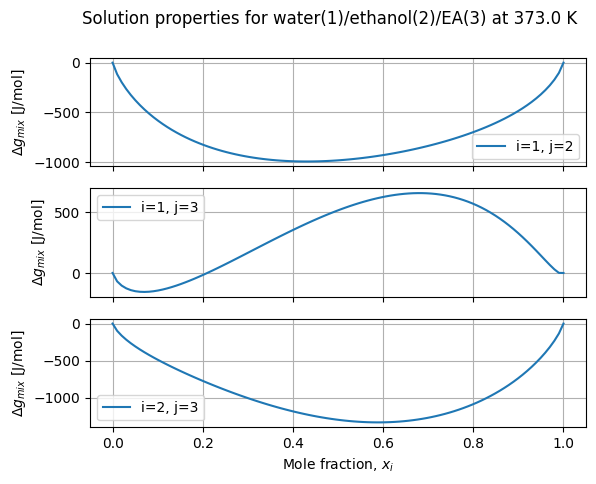

In [8]:
nplots = N*(N - 1)//2
fig, ax = plt.subplots(nplots, sharex=True)
fig.suptitle(f"Solution properties for water(1)/ethanol(2)/EA(3) at {T} K")
ax[-1].set_xlabel(r"Mole fraction, $x_{i}$")

T = 300. # K
xrange = np.linspace(0., 1., 100)

k = 0
for i in range(N):
    for j in range(i + 1, N):
        
        Dgmix = []
        x = np.zeros(N)
        for xval in xrange:
            x[i] = xval
            x[j] = 1. - xval
            Dgmix.append(acm.Dgmix(T, x))

        ax[k].grid(True)
        ax[k].set_ylabel(r"$\Delta g_{mix}$ [J/mol]")
        ax[k].plot(xrange, Dgmix, label=f"i={i+1}, j={j+1}")
        ax[k].legend(loc="best")
        
        k += 1


Notice the concave region in the middle plot, indicating a miscibility gap for the binary water/EA. Let us calculate and plot the corresponding Txx diagram. 

In [9]:
from scipy.optimize import minimize_scalar

# Temperature range
Trange = np.linspace(283., 315., 20)

# Array to hold the solubilities in both phases 
x1 = np.zeros((len(Trange), 2))

# Find solubility by minimizing Dgmix
for ib, bounds in enumerate([(0., 0.4), (0.9, 1.)]):
    for iT, T in enumerate(Trange):
        sol = minimize_scalar(lambda x: acm.Dgmix(T, np.array([x, 0., 1. - x])),
                              bounds=bounds)
        x1[iT, ib] = sol.x


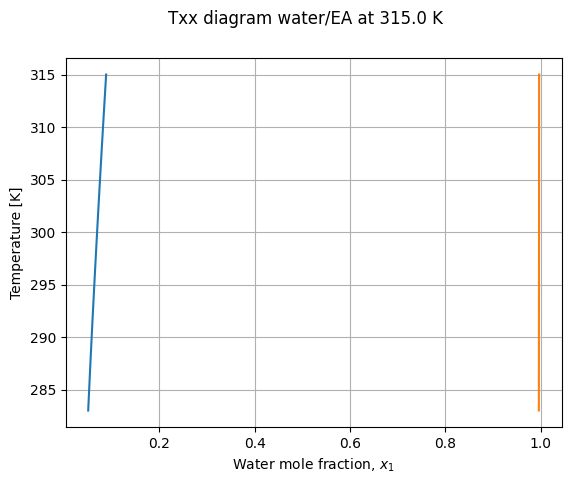

In [10]:
fig, ax = plt.subplots()
fig.suptitle(f"Txx diagram water/EA at {T} K")
ax.set_xlabel(r"Water mole fraction, $x_{1}$")
ax.set_ylabel("Temperature [K]")
ax.grid(True)

ax.plot(x1[:, 0], Trange)
ax.plot(x1[:, 1], Trange)

## Polymer solutions

To be done!